In [2]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc
import glob
import imageio


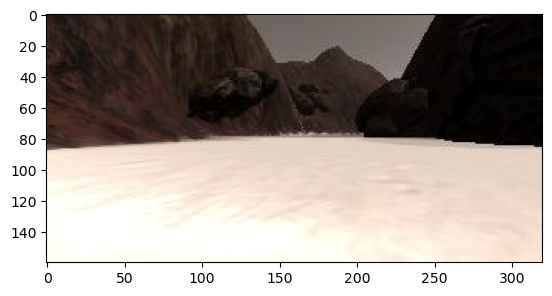

In [3]:
path = '../DataImages/IMG/*'
img_list = glob.glob(path)
image = mpimg.imread(img_list[0])
plt.imshow(image)

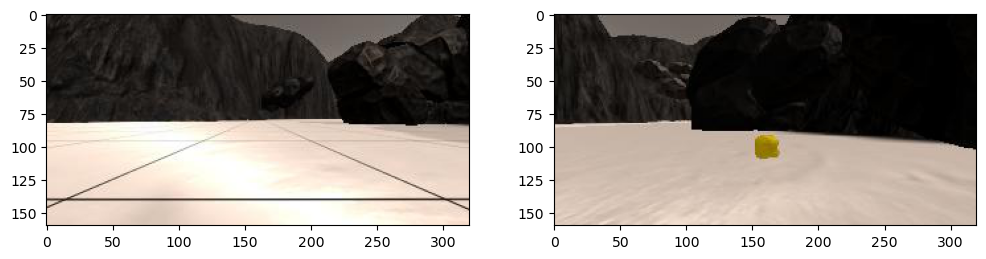

In [4]:
example_grid = "../calibration_images/example_grid1.jpg"
example_rock = "../calibration_images/example_rock1.jpg"
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

Text(0.5, 1.0, 'Grid image after perspective transform')

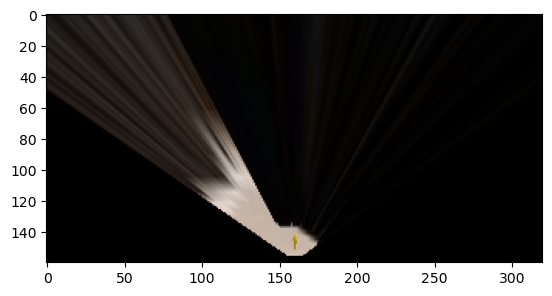

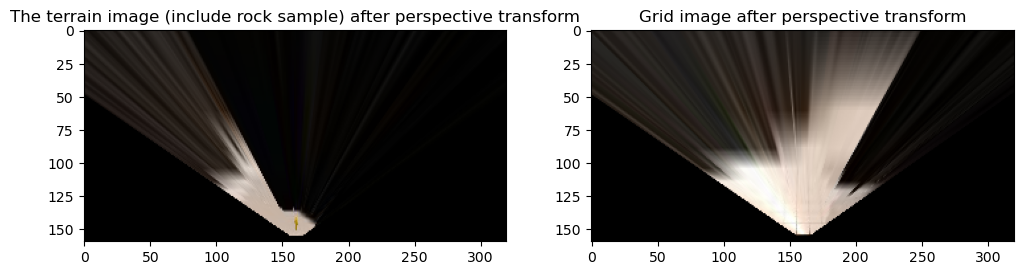

In [9]:
def perspect_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped


dst_size = 5
bottom_offset = 5
source = np.float32([[14,140],
                     [300,140],
                     [200,95],
                     [120,95]])

destination = np.float32([[image.shape[1] / 2 - dst_size, image.shape[0] - bottom_offset],
                          [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                          [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                          [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset]])

warped = perspect_transform(rock_img, source, destination)
plt.imshow(warped)

warped_grid = perspect_transform(grid_img,source,destination)
warped_navigable = perspect_transform(rock_img,source,destination)
warped_rock = warped_navigable
warped_obstacle = warped_navigable


fig = plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(warped_navigable) # same image for obstacle and rock
plt.title('The terrain image (include rock sample) after perspective transform')
plt.subplot(122)
plt.imshow(warped_grid)
plt.title('Grid image after perspective transform')


All images are in binary


Text(0.5, 1.0, 'Original image after perspective transform')

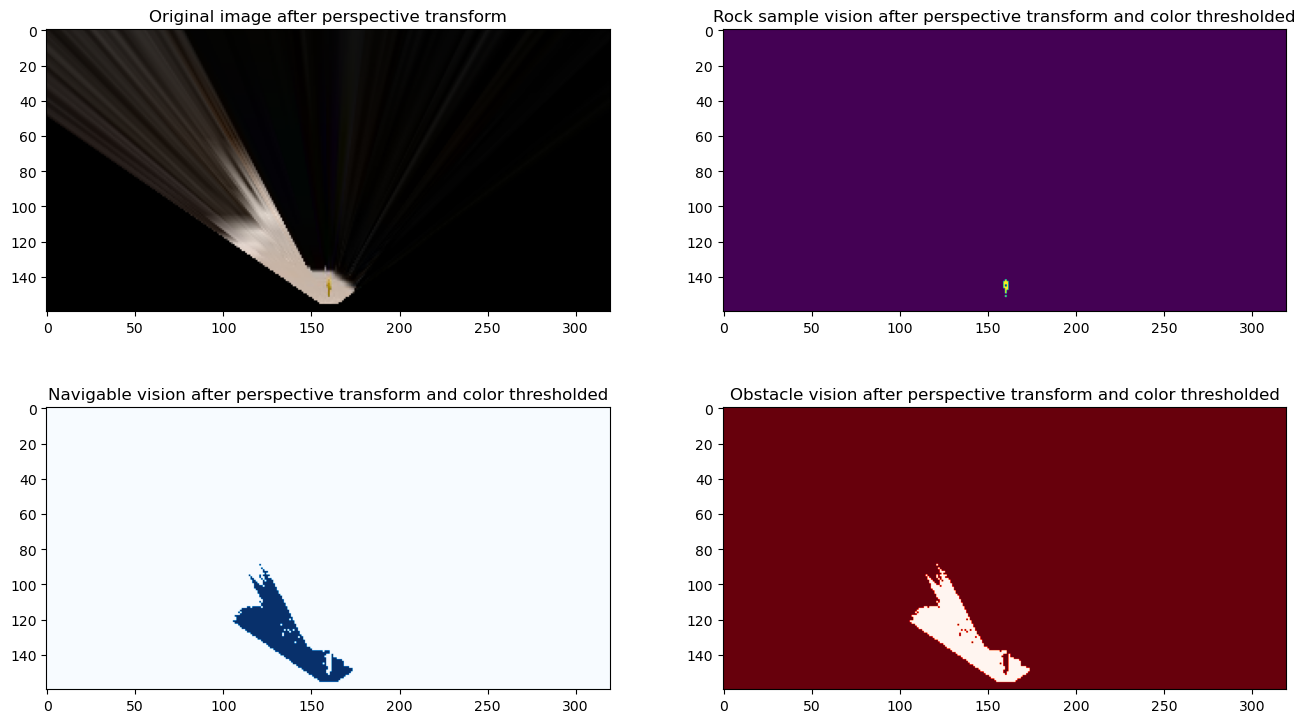

In [47]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

# Identify yellow rock sample
def color_thresh_rock(img):
    # note: yellow_hsv = [30,255,255] # H is 0-179 degree not 360
    # convert RGB image to HSV image
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    # define lowerbound and upperbound for yellow color
    lower_yellow = np.array([20,100,100])
    upper_yellow = np.array([40,255,255])
    # detect color in image by masking each pixel
    mask = cv2.inRange(hsv,lower_yellow,upper_yellow)
    result = cv2.bitwise_and(img,img,mask = mask)
    # convert result to binary
    binary_result = color_thresh(result,(0,0,0))
    # return binary result
    return binary_result


threshed_navigable = color_thresh(warped_navigable)
threshed_obstacle = 1-threshed_navigable # binary invert of navigable vision
threshed_rock = color_thresh_rock(warped_rock)

print('All images are in binary')


fig = plt.figure(figsize=(16,9))
plt.subplot(223)
#navigable terrain is in blue, rock is in white
plt.imshow(threshed_navigable, cmap='Blues')
plt.title('Navigable vision after perspective transform and color thresholded')
plt.subplot(224)
plt.imshow(threshed_obstacle,cmap='Reds')
#obstacles are in red, rock is in red
plt.title('Obstacle vision after perspective transform and color thresholded')
plt.subplot(222)
#the rock is in yellow on a purple background
plt.imshow(threshed_rock)
plt.title('Rock sample vision after perspective transform and color thresholded')
plt.subplot(221)
plt.imshow(warped_navigable)
#the rock is in yellow
plt.title('Original image after perspective transform')


/tmp/ipykernel_6356/1236549906.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
/tmp/ipykernel_6356/1236549906.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pixel = -(xpos - binary_img.shape[0]).astype(np.float)


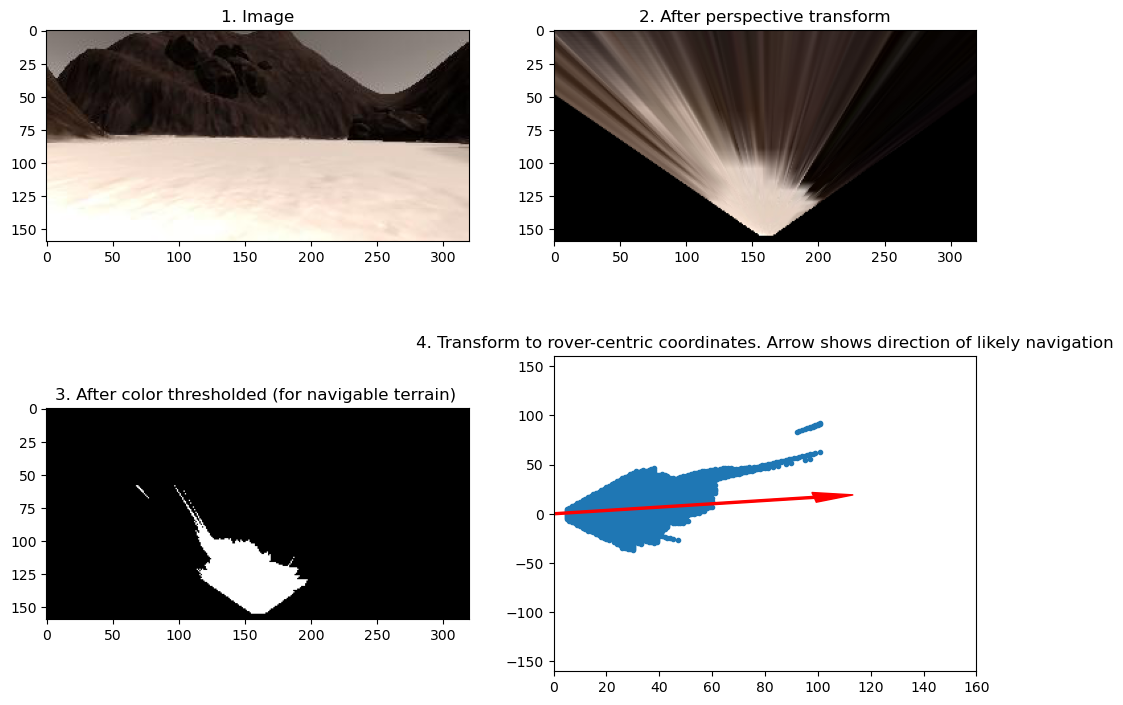

In [24]:
# Define a function to convert to rover-centric coordinates
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float)
    return x_pixel, y_pixel


# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dists = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dists, angles

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    # Apply a rotation
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))                         
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.title('1. Image')
plt.subplot(222)
plt.imshow(warped)
plt.title('2. After perspective transform')
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.title('3. After color thresholded (for navigable terrain) ')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
plt.title('4. Transform to rover-centric coordinates. Arrow shows direction of likely navigation')
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)


     
